<a href="https://colab.research.google.com/github/acse-srm3018/DeeplearningProxy/blob/main/Gridsearch/Pressure_Grid_Search_lr1e_4_batch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jul 25 19:01:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import files
files.upload()

Saving layers.py to layers.py
Saving unet_uae.py to unet_uae.py


{'layers.py': b'"""Import required libraries and modules."""\r\n\r\nimport tensorflow as tf\r\nfrom keras import backend as K\r\nfrom keras.engine.topology import Layer\r\nfrom keras.layers.merge import add\r\n# from keras.engine import InputSpec\r\nfrom keras.layers import InputSpec\r\nfrom keras.layers.core import Activation\r\nfrom keras.layers.convolutional import Conv2D, UpSampling2D\r\nfrom keras.layers import BatchNormalization, ConvLSTM2D\r\nfrom keras.layers import TimeDistributed, Reshape, RepeatVector\r\nfrom keras import regularizers\r\n\r\n\r\nreg_weights = 0.00001\r\n\r\n\r\ndef conv_bn_relu(filter_num, row_num, col_num, stride):\r\n    """\r\n    Create Convolutional Batch Norm layer.\r\n\r\n    Parameters:\r\n    ---------\r\n    filter_num : int\r\n    number of filters to use in convolution layer.\r\n    row_num : int\r\n    number of row\r\n    col_num : int\r\n    number of column\r\n    stride : int\r\n    size of stride\r\n    Returns:\r\n    ---------\r\n    conv

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
def load_data(path):
    """
    Function to load datasets in format .NPY
    
    Parameter:
    ----------
    path : string
        The absolute path of where data saved in local system
        
    Return:
    ----------
    loaded_data : ndarray
        The data which was loaded
    """
    loaded_data = np.load(path)
    return loaded_data

In [7]:
# Two common methods for feature scaling is : 1-Normalization & 2-Standardaisation

def normalize(data):
    """
    this function used for Max-Min Normalization (Min-Max scaling) by re-scaling
    features with a distribution value between 0 and 1. For every feature,the minimum
    value of that feature gets transformed into 0, and the maximum value 
    gets transformed into 1
    
    Parameter:
    ----------
    data : ndarray
        The numpy array which we want to normalize
        
    Return:
    ----------
    norm_data : ndarray
        The normalized data which transformed into 0 and 1
    """
    max_p = np.max(data[:, :, :, :])
    min_p = np.min(data[:, :, :, :])
    norm_data = (data - min_p)/(max_p - min_p)
    return norm_data

def standardize(data):
    """
    this function used for rescaling faetures to ensure the mean
    and the standard deviation to be 0 and 1, respectively.
    
    Parameter:
    ----------
    data : ndarray
        The numpy array which we want to normalize
        
    Return:
    ----------
    data : ndarray
        The standardized data which the mean
    and the standard deviation to be 0 and 1
    """
    data_mean = np.mean(data[:, :, :, :], axis = 0, keepdims = True)
    data_std = np.std(data[:, :, :, :], axis = 0, keepdims = True)
    std_data = (data - data_mean)/(data_std)
    return std_data

In [8]:
# define the absolute path of training datatsat
path_perm = '/content/gdrive/MyDrive/perm.npy'
path_press = '/content/gdrive/MyDrive/pressure.npy'
# use load_data function nd above path to loading data
X_data= load_data(path_perm)
target_data = load_data(path_press)

In [9]:
# Normalize data using abov normalize function
train_nr = 2250
test_nr = 750

In [10]:
p_t_mean = np.mean(target_data[:train_nr, ...], axis = 0, keepdims = True)
target_data = target_data - p_t_mean
print('max p is ', np.max(target_data[:train_nr, ...]), ', min p is ', np.min(target_data[:train_nr, ...]))
max_p = np.max(target_data[:train_nr, ...])
min_p = np.min(target_data[:train_nr, ...])
target_data = (target_data - min_p)/(max_p -min_p) - 0.5
print('max p is ', np.max(target_data), ', min p is ', np.min(target_data))
print('max p train is ', np.max(target_data[:train_nr, ...]), ', min p train is ', np.min(target_data[:train_nr, ...]))

max p is  516.6753418240017 , min p is  -135.6267126736111
max p is  0.5039995270719013 , min p is  -0.500166926837037
max p train is  0.5 , min p train is  -0.5


In [11]:
input_shape=(100, 100, 2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary()

output shape is  (None, 10, 100, 100, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 100, 100, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 16)   304         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 50, 16)   0           batch_normalization[0][0]        
_____________________________________________________

In [12]:
depth = 10
nr = X_data.shape[0]
train_nr = 2250
test_nr = 750
train_x = np.concatenate([X_data[:train_nr,[0], ...],target_data[:train_nr,[0], ...]], axis = 1)
train_y = target_data[:train_nr, ...]

test_x = np.concatenate([X_data[nr-test_nr:,[0], ...], target_data[nr-test_nr:, [0], ...]], axis = 1)
test_y = target_data[nr-test_nr:,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (2250, 100, 100, 2)
train_y shape is  (2250, 10, 100, 100, 1)
test_x shape is  (750, 100, 100, 2)
test_y shape is  (750, 10, 100, 100, 1)


In [25]:
output_dir = '/content/gdrive/MyDrive/Colab Notebooks/saved_models/'
epochs = 300
batch_size = 4
num_batch = int(train_nr/batch_size) 

In [19]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [20]:
opt = Adam(learning_rate=1e-4)
vae_model.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [21]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 15, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = 'saved-model-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', save_freq = 20)

callbacks_list = [lrScheduler, checkPoint]

In [26]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y))

Epoch 1/300
563/563 [==============================] - 71s 125ms/step - loss: 1764.9927 - relative_error: -0.2973 - val_loss: 517.7518 - val_relative_error: -0.1923
Epoch 2/300
563/563 [==============================] - 67s 118ms/step - loss: 309.1549 - relative_error: -0.1460 - val_loss: 254.2977 - val_relative_error: -0.1321
Epoch 3/300
563/563 [==============================] - 67s 119ms/step - loss: 197.3738 - relative_error: -0.1182 - val_loss: 175.8051 - val_relative_error: -0.1127
Epoch 4/300
563/563 [==============================] - 67s 119ms/step - loss: 147.4164 - relative_error: -0.1026 - val_loss: 136.0072 - val_relative_error: -0.0994
Epoch 5/300
563/563 [==============================] - 67s 118ms/step - loss: 118.7958 - relative_error: -0.0923 - val_loss: 117.2762 - val_relative_error: -0.0918
Epoch 6/300
563/563 [==============================] - 67s 119ms/step - loss: 133.1320 - relative_error: -0.0962 - val_loss: 115.5355 - val_relative_error: -0.0879
Epoch 7/300
563

dict_keys(['loss', 'relative_error', 'val_loss', 'val_relative_error'])


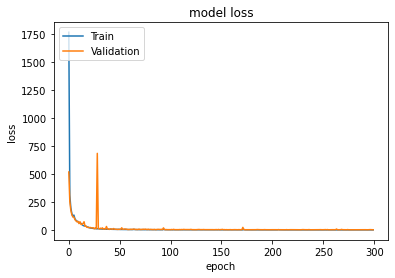

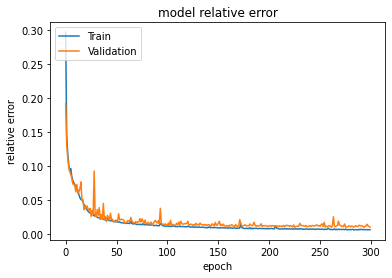

In [27]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.abs(history.history['relative_error']))
plt.plot(np.abs(history.history['val_relative_error']))
plt.title('model relative error')
plt.ylabel('relative error')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/Gridsearch_images/pressure_lr1-4_300epochs_adam_batch4.png')

In [ ]:
#vae_model.save("/content/gdrive/MyDrive/saved_models/pressure_le1-2.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
